In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
c = 3e10 # cm/s, speed of light
kB = 1.4e-16 # cgs, Boltzmann constant
mp = 1e-24 # g, proton mass
A21 = 10 # s^-1, Einstein A of LyA
L21 = 15e-4 # cm, wavelength of LyA
F21 = c / L21 # Hz, frequency of LyA

def lorentz(nu, A=A21, nu0=F21):
    """Return a Lorentzian line profile function evaluated at the specified frequencies.
    Arguments:
        nu: spectral frequency [Hz]
        A: Einstein A coefficient [s^-1], default: LyA
        nu0: center frequency [Hz], default: LyA"""
    ans = A/(4*np.pi)**2 / ((nu - nu0)**2 + (A/(4*np.pi))**2)
    return ans / ans.sum()

def doppler(nu, T, nu0=F21):
    """Return a Gaussian line profile function evaluated at the specified frequencies.
    Arguments:
        nu: spectral frequency [Hz]
        T: Temperature [K]
        nu0: center frequency [Hz], default: LyA"""
    dnu = np.sqrt(2 * kB * T / mp) / L21
    ans = 1./(dnu * np.sqrt(np.pi)) * np.exp(-(nu-nu0)**2/dnu**2)
    return ans / ans.sum()

def voigt(nu, T, A=A21, nu0=F21):
    """Return a Voigt line profile function evaluated at the specified frequencies.
    Arguments:
        nu: spectral frequency [Hz]
        T: Temperature [K]
        A: Einstein A coefficient [s^-1], default: LyA
        nu0: center frequency [Hz], default: LyA"""
    phi_lorentz = lorentz(nu=nu, A=A, nu0=nu0)
    phi_doppler = doppler(nu=nu, T=T, nu0=nu0)
    phi_voigt = np.convolve(phi_lorentz, phi_doppler, mode='same')
    phi_voigt_norm = phi_voigt/sum(phi_voigt)
    return phi_voigt_norm

def sigma(nu, A, T, nu0=F21):
    """Return the cross-section for photon absorption."""
    lamb0 = c/nu0
    return lamb0**2/(8*np.pi) * A * voigt(nu=nu, T=T, A=A, nu0=nu0)

<h2>1.1</h2>

In [3]:
nu_vec_fine = np.linspace(0.9995 * F21, 1.0005 * F21, 10000)
T = 255 # K

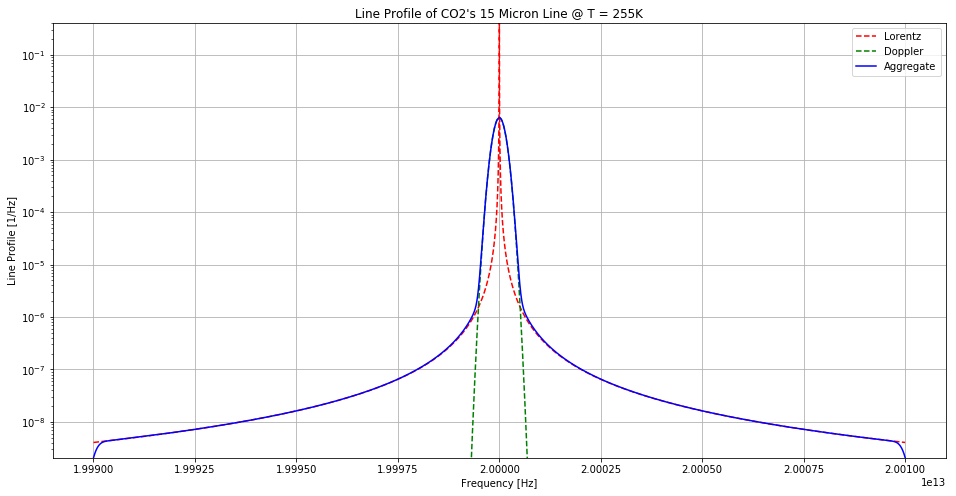

In [4]:
prof_lorentz = lorentz(nu=nu_vec_fine, A=A21, nu0=F21)
prof_doppler = doppler(nu=nu_vec_fine, T=T, nu0=F21)
prof_voigt = voigt(nu=nu_vec_fine, T=T, A=A21, nu0=F21)

plt.rcParams['figure.figsize'] = (16, 8)

plt.semilogy(nu_vec_fine, prof_lorentz, 'r--', label='Lorentz')
plt.semilogy(nu_vec_fine, prof_doppler, 'g--',  label='Doppler')
plt.semilogy(nu_vec_fine, prof_voigt, 'b', label='Aggregate')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Line Profile [1/Hz]')
plt.title(f'Line Profile of CO2\'s 15 Micron Line @ T = {T}K')
plt.ylim((min(prof_voigt), max(max(prof_lorentz), max(prof_doppler), max(prof_voigt))))

plt.grid(True)
plt.legend()

<h2>1.2</h2>

In [5]:
nu_vec_coarse = np.logspace(np.log10(F21)-2, np.log10(F21)+2, 1000)
nu_vec_both = np.sort(np.concatenate([nu_vec_fine, nu_vec_coarse]))

hbar = 1e-27 # erg.s
h = hbar*2*np.pi # erg/Hz
tau0 = 3 # optical depth at line center

def planck_fun(nu_vec, T):
    '''
    Inputs:
        nu_vec: Numpy vector of floats. Frequencies in Hz.
        T: Float. Temperature in K.
    Outputs:
    '''
    return 2*h*nu_vec**3/c**2 * 1/(np.exp(h*nu_vec/(kB*T)) - 1)

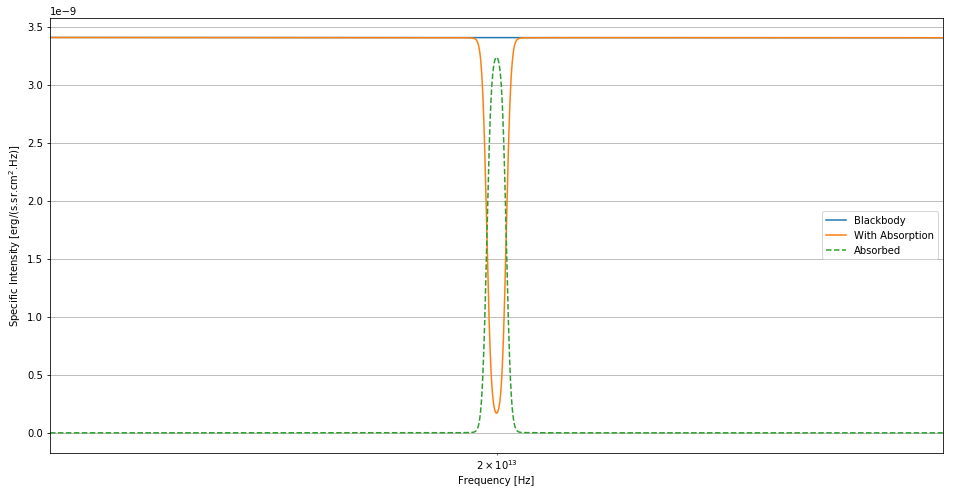

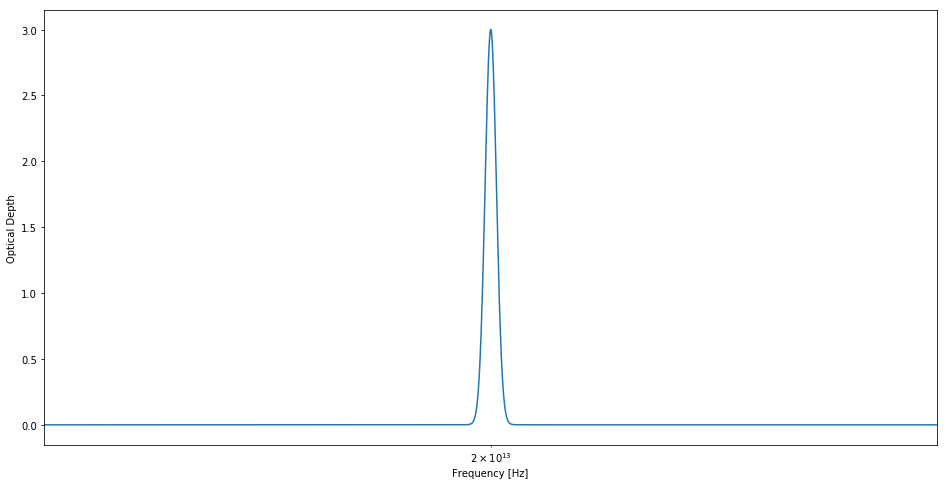

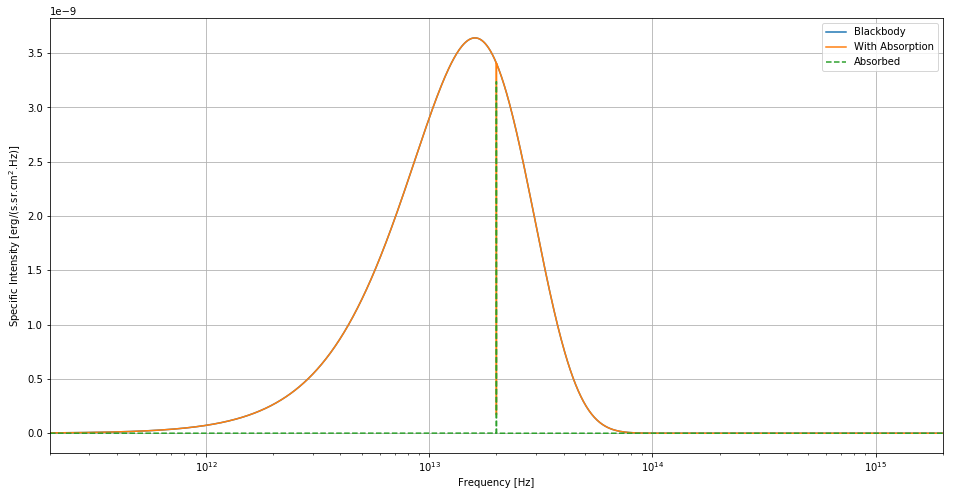

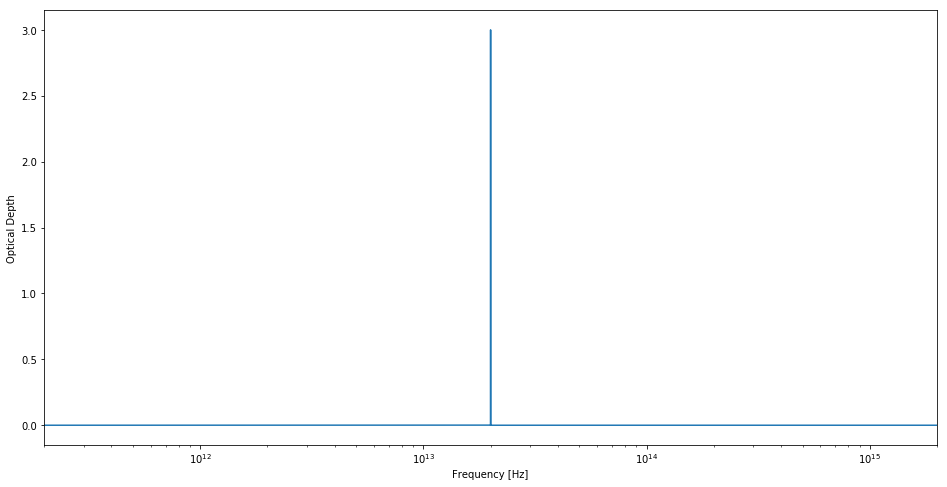

In [27]:
for nu_vec in (nu_vec_fine, nu_vec_both):
    # Blackbody radiation
    B_blackbody = planck_fun(nu_vec=nu_vec, T=T)

    # Incorporating 15um line absorption
    ## x-section (as a function of frequency)
    sigma_vec = sigma(nu_vec, A=A21, T=T, nu0=F21)

    ## getting column density of CO2 given tau=3 @ line center
    idx = np.argwhere(np.diff(np.sign(nu_vec-F21))).flatten()[0] # idx of nearest nu to nu0
    N = tau0/sigma_vec[idx]

    ## getting optical depth across different frequencies
    tau_vec = N * sigma_vec
    B_wabs = np.multiply(B_blackbody, np.exp(-tau_vec))
    plt.figure()
    plt.semilogx(nu_vec, B_blackbody, label='Blackbody')
    plt.semilogx(nu_vec, B_wabs, label='With Absorption')
    plt.semilogx(nu_vec, B_blackbody-B_wabs, '--', label='Absorbed')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Specific Intensity [erg/(s.sr.cm$^2$.Hz)]')
    plt.legend()
    plt.grid(True)
    plt.xlim((min(nu_vec), max(nu_vec)))
    
    plt.figure()
    plt.semilogx(nu_vec, tau_vec)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Optical Depth')
    plt.xlim((min(nu_vec), max(nu_vec)))

<h2>1.3</h2>

In [37]:
# Trapezoidal integration for total absorption by CO2
F_diff = np.trapz(B_diff, nu_vec) * 4*np.pi

# Absorption in optically thick region by CO2
F_diff_thick = 0
for i, tau_curr in enumerate(tau_vec[:-1]):
    tau_next = tau_vec[i+1]
    # To avoid counting over optically thin region
    if tau_curr > 1 and tau_next > 1:
        dnu = nu_vec[i+1] - nu_vec[i]
        B_diff_thick = (B_diff[i+1] + B_diff[i])/2
        F_diff_thick = 4*np.pi * B_diff_thick * dnu
        
# print('NB: Dropped a steradian normalization (doesn\'t affect the final fraction)\n')
print(f'Blackbody:\t\t\t{4*np.pi*np.trapz(B_blackbody, nu_vec)} erg/(s.cm^2)')
print(f'With Absorption:\t\t{4*np.pi*np.trapz(B_wabs, nu_vec)} erg/(s.cm^2)')
print(f'Total Absorption:\t\t{F_diff} erg/(s.cm^2)')
print(f'->  Optically Thick:\t\t{F_diff_thick} erg/(s.cm^2)')
print(f'Optically Thick Fraction:\t{F_diff_thick/F_diff}')

Blackbody:			1187528.5832255986 erg/(s.cm^2)
With Absorption:		1187509.7438671126 erg/(s.cm^2)
Total Absorption:		18.839358485997558 erg/(s.cm^2)
->  Optically Thick:		0.054932048918363015 erg/(s.cm^2)
Optically Thick Fraction:	0.0029158131344648236


<h2>1.4</h2>

In [50]:
sigma_blackbody = 2 * np.pi**5 * kB**4 / (15 * c**2 * h**3) # blackbody constant = Fblackbody/T^4

F_Earth_woabs = sigma_blackbody * T**4
F_Earth_compensate = (F_Earth_woabs + F_diff)
T_new = (F_Earth_compensate / sigma_blackbody)**.25
print(f'OG Temperature:\t\t{T} K')
print(f'New Temperature:\t{T_new} K')
print(f'Temp. Difference:\t{T_new - T} K')

OG Temperature:		255 K
New Temperature:	255.00404535943025 K
Temp. Difference:	0.004045359430250528 K
